# Global population stratification with AutoGMM clustering

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from graspy.cluster.autogmm import AutoGMMCluster
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

import random

In [2]:
pyo.init_notebook_mode()
random.seed(42)

### Download PCA dataset

In [3]:
df = pd.read_csv('../data/all_pca.txt', sep='\t').reset_index().rename(columns={'index':'s'})

In [4]:
df.head(3)

s       PC1       PC2       PC3       PC4       PC5       PC6  \
0  0002A -0.003756  0.002480 -0.003705 -0.006913 -0.001583  0.003276   
1  0003A -0.008264  0.005392  0.002756 -0.006069 -0.008450  0.007290   
2  0004A -0.009552  0.004057 -0.000463 -0.004752 -0.009075  0.003313   

        PC7       PC8       PC9      PC10  
0 -0.003737 -0.000719  0.006406  0.001583  
1 -0.013843  0.018493 -0.007315  0.001393  
2 -0.016355 -0.003091 -0.006026 -0.002958

### Download phenotype information

In [5]:
pheno = pd.read_csv('../data/fsgs.phe', sep='\t')
df = pd.merge(df, pheno, left_on='s', right_on='ID').drop(['batch', 'ID'], axis=1)
df['fsgs'] = np.where(df['FSGS']==1, 'control', 'case')

In [7]:
pheno.head(3)

ID  FSGS   batch
0   05-05     2  batch1
1   05-12     2  batch1
2  07-015     2  batch1

In [6]:
df.head(3)

s       PC1       PC2       PC3       PC4       PC5       PC6  \
0  0002A -0.003756  0.002480 -0.003705 -0.006913 -0.001583  0.003276   
1  0003A -0.008264  0.005392  0.002756 -0.006069 -0.008450  0.007290   
2  0004A -0.009552  0.004057 -0.000463 -0.004752 -0.009075  0.003313   

        PC7       PC8       PC9      PC10  FSGS     fsgs  
0 -0.003737 -0.000719  0.006406  0.001583     1  control  
1 -0.013843  0.018493 -0.007315  0.001393     1  control  
2 -0.016355 -0.003091 -0.006026 -0.002958     1  control

### Apply AutoGMM Clustering

In [8]:
X = df.loc[:, 'PC1':'PC10']
# normalize PCA for easier parameter selection
X = preprocessing.StandardScaler().fit_transform(X)
# initializate clustering algorithm
autogmm = AutoGMMCluster(min_components=1, max_components=X.shape[1],
                         affinity='euclidean',linkage='all',covariance_type='all',
                         random_state=0)
# apply clustering algorithm
clusters = autogmm.fit_predict(X)
# add information about predicted clusters
df['cluster'] = clusters

In [9]:
df.head(3)

s       PC1       PC2       PC3       PC4       PC5       PC6  \
0  0002A -0.003756  0.002480 -0.003705 -0.006913 -0.001583  0.003276   
1  0003A -0.008264  0.005392  0.002756 -0.006069 -0.008450  0.007290   
2  0004A -0.009552  0.004057 -0.000463 -0.004752 -0.009075  0.003313   

        PC7       PC8       PC9      PC10  FSGS     fsgs  cluster  
0 -0.003737 -0.000719  0.006406  0.001583     1  control        3  
1 -0.013843  0.018493 -0.007315  0.001393     1  control        5  
2 -0.016355 -0.003091 -0.006026 -0.002958     1  control        5

### Visualize AutoGMM-clusters (1)

In [10]:
def plot_strat(data, group, clusters, title, figsize=(20, 20), alpha_list=None):
    '''PCA-scatterplot & sample counts per cluster'''
    sns.set(style="whitegrid", font_scale=1.6);

    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=30, y=0.94)
    nrow = 4
    grid = plt.GridSpec(nrow, 3, hspace=0.35, wspace=0.3)

    # add scatter plots on the top of the grid
        
    if alpha_list is None:
        alpha_list = [0.4]*len(clusters)
        
    for i, pcx, pcy in zip(range(nrow),
       [['PC1', 'PC1', 'PC2'], ['PC4', 'PC4', 'PC5'], ['PC7', 'PC7', 'PC8'], ['PC7', 'PC8', 'PC9']],
       [['PC2', 'PC3', 'PC3'], ['PC5', 'PC6', 'PC6'], ['PC8', 'PC9', 'PC9'], ['PC10', 'PC10', 'PC10']]):
        for xlab, ylab, j in zip(pcx, pcy, [0, 1, 2]):
            ax = plt.subplot(grid[i, j])
            for gr, col, a in zip(clusters, sns.color_palette('Set1')[:len(clusters)][::-1], alpha_list):
                sns.scatterplot(x=xlab, y=ylab, data=data[data[group]==gr], alpha=a, color=col,
                                ax=ax, legend='full');
            ax.legend(clusters)
            for lh in ax.legend_.legendHandles:
                lh.set_sizes([100])
                lh.set_alpha(1)

            ax.set(xlabel=xlab, ylabel=ylab)
    print(Counter(data[data[group].isin(clusters)][group]))

Counter({3: 5104, 2: 3200, 5: 2492, 1: 816, 7: 753, 6: 581, 4: 505, 0: 260})


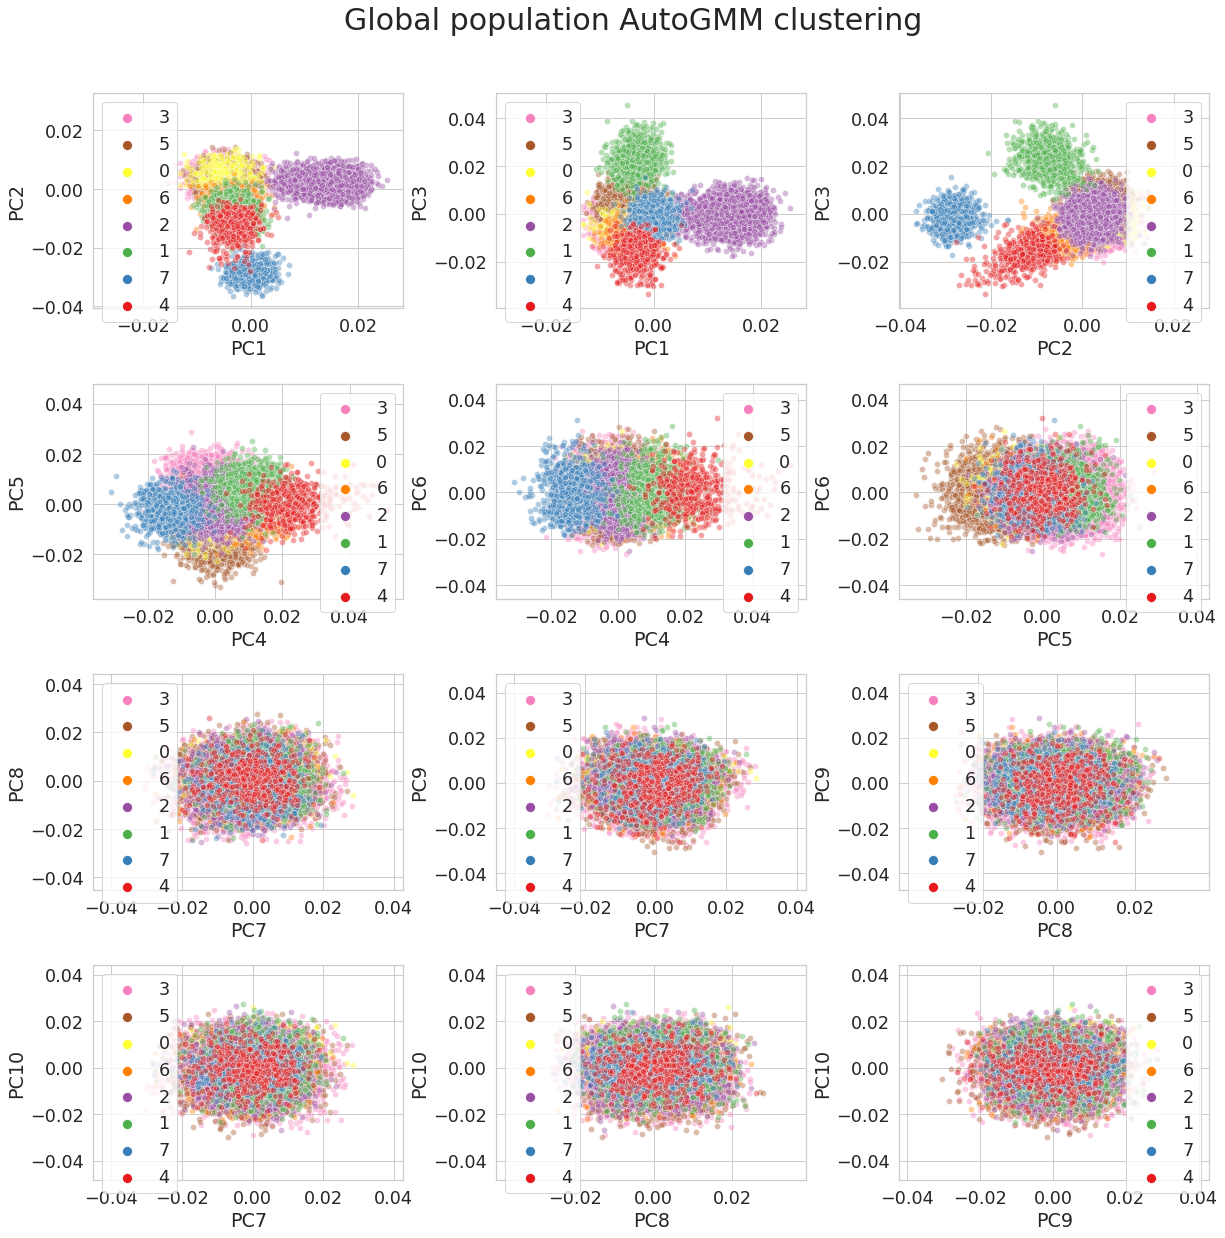

In [11]:
plot_strat(df, 'cluster', df['cluster'].unique(), 'Global population AutoGMM clustering')

### Visualize AutoGMM-clusters (2)

In [12]:
pc = ['PC1', 'PC2', 'PC3']
# plot 3d PCA-scatterplot
fig = go.Figure()
for i in range(0, len(df['cluster'].unique())):
    fig.add_trace(
        go.Scatter3d(
            mode='markers',
            x = df.loc[df['cluster']==i, pc[0]],
            y = df.loc[df['cluster']==i, pc[1]],
            z = df.loc[df['cluster']==i, pc[2]],
        opacity=0.7,
        marker=dict(
            color=i,
            size=4,
            line=dict(
                width=0
            )
        ),
        name=i,
        showlegend=True
    )
)
fig.update_layout(
    scene = dict(
        xaxis_title=pc[0],
        yaxis_title=pc[1],
        zaxis_title=pc[2]),
    width=700,
    title={'text':"Global population stratification. AutoGMM-clustering"},
    legend= {'title': 'Cluster #', 'itemsizing': 'constant'},
     margin=dict(r=20, b=10, l=10, t=40)
)
# fig.write_html("population_clustering.html")
fig.show()

### Presence case/control per cluster

In [13]:
pd.DataFrame(df.groupby(['cluster', 'fsgs']).count()['PC1'])\
            .rename(columns={'PC1':'count_per_group'})\
            .unstack(level=1)

count_per_group        
fsgs               case control
cluster                        
0                     8     252
1                     9     807
2                   141    3059
3                   302    4802
4                    29     476
5                    48    2444
6                    23     558
7                    17     736

### AutoGMM-clustering overlap with 1000 genome annotation

In [14]:
kg = pd.read_csv('../data/1kg_annotations.txt', sep='\t')\
            .loc[:, ['Sample', 'SuperPopulation']]\
            .rename(columns={'Sample':'s', 'SuperPopulation':'pop'})
df = pd.merge(kg, df, how='right').fillna({'not_in_1kg':'pop'}).fillna({'pop':'not_in_1kg'})

In [15]:
kg.head(3)

s  pop
0  HG00096  EUR
1  HG00097  EUR
2  HG00098  EUR

In [16]:
df.head(3)

s  pop       PC1       PC2       PC3       PC4       PC5       PC6  \
0  HG00096  EUR -0.009756  0.005238 -0.001137 -0.010193  0.014237  0.001733   
1  HG00097  EUR -0.003446  0.006234 -0.002472 -0.000665  0.005578  0.006293   
2  HG00099  EUR -0.001266  0.005458  0.004012  0.003915  0.019475 -0.015382   

        PC7       PC8       PC9      PC10  FSGS     fsgs  cluster  
0 -0.008342  0.014042  0.005066 -0.003560     1  control        3  
1 -0.002929  0.010825 -0.012017 -0.004753     1  control        3  
2 -0.000600 -0.003235 -0.014815  0.002710     1  control        3

In [17]:
df['pop'].unique()

array(['EUR', 'EAS', 'AMR', 'SAS', 'AFR', 'not_in_1kg'], dtype=object)

Counter({'not_in_1kg': 12007, 'AFR': 467, 'EUR': 365, 'SAS': 324, 'EAS': 318, 'AMR': 230})


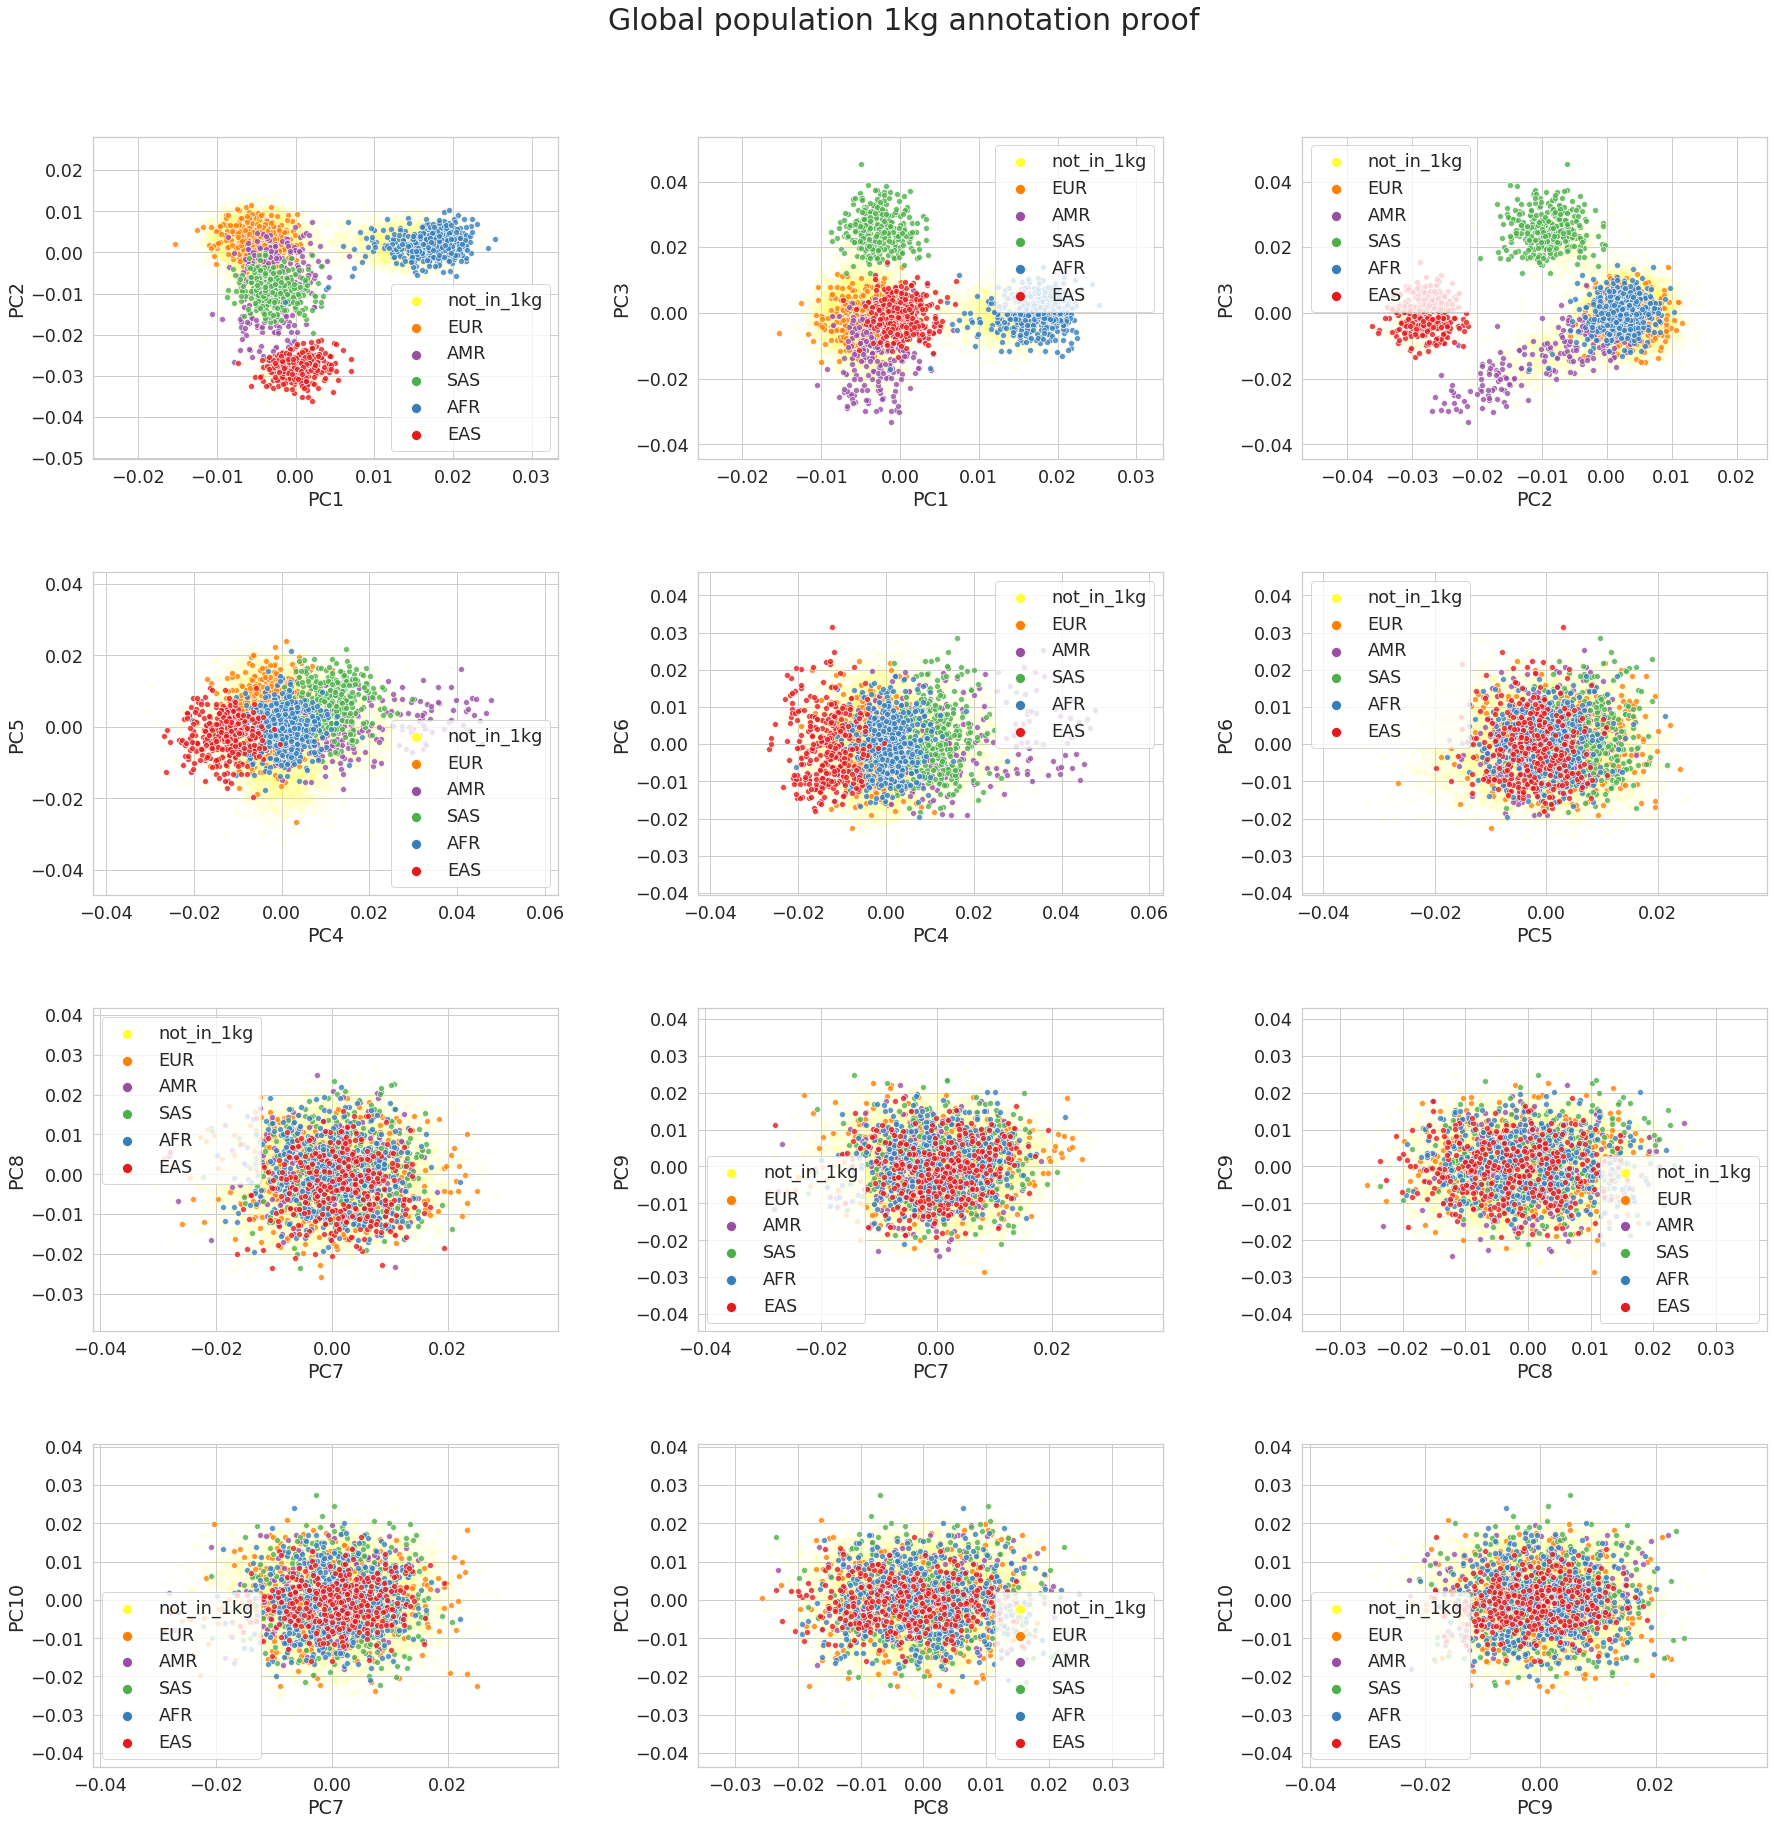

In [18]:
plot_strat(df, 'pop',
           ['not_in_1kg', 'EUR', 'AMR', 'SAS', 'AFR', 'EAS'],
           alpha_list=[0.05, 0.8, 0.8, 0.8, 0.8, 0.8],
           title='Global population 1kg annotation proof', figsize=(30, 30))

In [19]:
df.to_csv('../data/all_pca.annotated.tsv', sep='\t', index=False)